In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import SelectKBest, mutual_info_regression
#pip install statsmodels
import statsmodels.api as sm

In [454]:
# Open data sets
props = pd.read_csv('../data/curated/places_property.csv')
external = pd.read_csv('../data/landing/Property_external.csv')

In [455]:
props

,Address,Suburb,Prices,Type_Apartment,Type_House,Type_Townhouse,Estimated resident population (no.),Population density (persons/km2),Median age - persons (years),Working age population (aged 15-64 years) (no.),...,"Used at least one form of public transport (train, tram, bus, ferry) (no.)",Extracted_Address,latitude,longitude,num_stops,num_stations,num_schools,num_landmarks,distance to CBD,total_transport
0,"39 Durham Crescent, \nHOPPERS CROSSING VIC 3029",HOPPERS CROSSING,450.0,0,1,0,37666.0,4420.4,74.1,25272.0,...,884.0,"39 Durham Crescent, \nHOPPERS CROSSING VIC 3029",-37.872563,144.686795,0.0,0.0,14.0,0.0,45.1,0.0
1,"7/1 Mabel Street, \nIVANHOE VIC 3079",IVANHOE,450.0,0,0,1,12561.0,2487.4,40.9,8357.0,...,343.0,"1 Mabel Street, \nIVANHOE VIC 3079",-37.761896,145.029437,0.0,0.0,19.0,0.0,8.7,0.0
2,"2/59 Green Street, \nIVANHOE VIC 3079",IVANHOE,450.0,1,0,0,12561.0,2487.4,40.9,8357.0,...,343.0,"59 Green Street, \nIVANHOE VIC 3079",-37.764732,145.035655,0.0,0.0,25.0,0.0,7.8,0.0
3,"104/15 Ivanhoe Parade, \nIVANHOE VIC 3079",IVANHOE,450.0,1,0,0,12561.0,2487.4,40.9,8357.0,...,343.0,"15 Ivanhoe Parade, \nIVANHOE VIC 3079",-37.767678,145.045093,0.0,1.0,21.0,0.0,8.5,1.0
4,"63 Dunne Street, \nKINGSBURY VIC 3083",KINGSBURY,450.0,0,1,0,10564.0,1172.6,34.0,7808.0,...,382.0,"63 Dunne Street, \nKINGSBURY VIC 3083",-37.714056,145.037364,1.0,0.0,19.0,0.0,12.1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4197,"156 Black Forest Road, \nWYNDHAM VALE VIC 3024",WYNDHAM VALE,465.0,0,1,0,22858.0,2941.3,63.4,15428.0,...,651.0,"156 Black Forest Road, \nWYNDHAM VALE VIC 3024",-37.899498,144.609698,0.0,0.0,7.0,0.0,57.7,0.0
4198,"104/118 Pier Street, \nALTONA VIC 3018",ALTONA,470.0,1,0,0,28738.0,1704.2,78.8,18016.0,...,600.0,"118 Pier Street, \nALTONA VIC 3018",-37.868826,144.830352,0.0,1.0,5.0,0.0,22.5,1.0
4199,"2/35 Ailsa Street, \nALTONA MEADOWS VIC 3028",ALTONA MEADOWS,470.0,0,1,0,18665.0,1770.6,40.9,12311.0,...,380.0,"35 Ailsa Street, \nALTONA MEADOWS VIC 3028",-37.870238,144.762616,0.0,1.0,0.0,0.0,38.5,1.0
4200,"6 Stringybark Court, \nBERWICK VIC 3806",BERWICK,470.0,0,1,0,23187.0,1174.1,43.3,14432.0,...,241.0,"6 Stringybark Court, \nBERWICK VIC 3806",-38.026246,145.324107,0.0,0.0,0.0,0.0,56.5,0.0


In [456]:
store = list(props['Address'])

In [457]:
# Only take properties that already been filtered by props
filtered_df = external[external['Address'].isin(store)]
filtered_df = filtered_df.reset_index(drop=True)

In [458]:
# Check whether the address filtered match the address in props (in the same order)
a = filtered_df['Address']
a = a.reset_index(drop=True)
b = props['Address']
a.equals(b)

True

In [466]:
# Get the property details of the addresss
bedroom = filtered_df['Bedroom']
bathroom = filtered_df['Bathroom']
parking = filtered_df['Parking']
med = filtered_df['Median equivalised total household income (weekly) ($)']

In [467]:
# Insert the information to props dataframe to generate complete dataset
props['Bedroom'] = bedroom
props['Bathroom'] = bathroom
props['Parking'] = parking
props['Median equivalised total household income (weekly) ($)'] = med

In [468]:
# Cleaning data and type casting
props['Bedroom'] = props['Bedroom'].replace([' '], '0')
props['Bathroom'] = props['Bathroom'].replace([' '], '0')
props['Parking'] = props['Parking'].replace([' '], '0')
props['Bedroom'] = props['Bedroom'].astype(int)
props['Bathroom'] = props['Bathroom'].astype(int)
props['Parking'] = props['Parking'].astype(int)

In [469]:
# Contains property data set with all internal and external features
props.to_csv('../data/curated/complete_dataset.csv')

In [470]:
len(props)

4202

In [471]:
props.columns

Index(['Address', 'Suburb', 'Prices', 'Type_Apartment', 'Type_House',
       'Type_Townhouse', 'Estimated resident population (no.)',
       'Population density (persons/km2)', 'Median age - persons (years)',
       'Working age population (aged 15-64 years) (no.)', 'Employed (no.)',
       'Unemployed (no.)', 'Renter (no.)',
       'Health care and social assistance (no.)',
       'Financial and insurance services (no.)',
       'Administrative and support services (no.)',
       'Education and training (no.)', 'Accommodation and food services (no.)',
       'Public administration and safety (no.)',
       'Value of residential building ($m)', 'Houses - total (no.)',
       'Townhouses - total (no.)', 'Apartments - total (no.)',
       'Median weekly household rental payment ($)', 'Rented (no.)',
       'Count of homeless persons (no.)',
       'Used at least one form of public transport (train, tram, bus, ferry) (no.)',
       'Extracted_Address', 'latitude', 'longitude', 'num_stops'

In [472]:
features = [
    'Type_Apartment', 'Type_House',
       'Type_Townhouse', 'Estimated resident population (no.)',
       'Population density (persons/km2)', 'Median age - persons (years)',
       'Working age population (aged 15-64 years) (no.)', 'Renter (no.)',
       'Health care and social assistance (no.)',
       'Financial and insurance services (no.)',
       'Administrative and support services (no.)',
       'Education and training (no.)', 'Accommodation and food services (no.)',
       'Public administration and safety (no.)',
       'Value of residential building ($m)', 'Houses - total (no.)',
       'Townhouses - total (no.)', 'Apartments - total (no.)',
       'Median weekly household rental payment ($)', 'Rented (no.)',
       'Count of homeless persons (no.)',
       'Used at least one form of public transport (train, tram, bus, ferry) (no.)',
       'total_transport', 'num_schools', 'num_landmarks', 'distance to CBD',
       'Bedroom', 'Bathroom', 'Parking',
       'Median equivalised total household income (weekly) ($)'
       ]

props['Prices'] = props['Prices'].astype(float)
X = props[features]
y= props['Prices']


In [473]:
X.dtypes

Type_Apartment                                                                  int64
Type_House                                                                      int64
Type_Townhouse                                                                  int64
Estimated resident population (no.)                                           float64
Population density (persons/km2)                                              float64
Median age - persons (years)                                                  float64
Working age population (aged 15-64 years) (no.)                               float64
Renter (no.)                                                                  float64
Health care and social assistance (no.)                                       float64
Financial and insurance services (no.)                                        float64
Administrative and support services (no.)                                     float64
Education and training (no.)                          

In [475]:
# Filter properties that have bedroom(s)
X = X[X['Bedroom'] != 0]

In [476]:
len(features)

30

<Axes: >

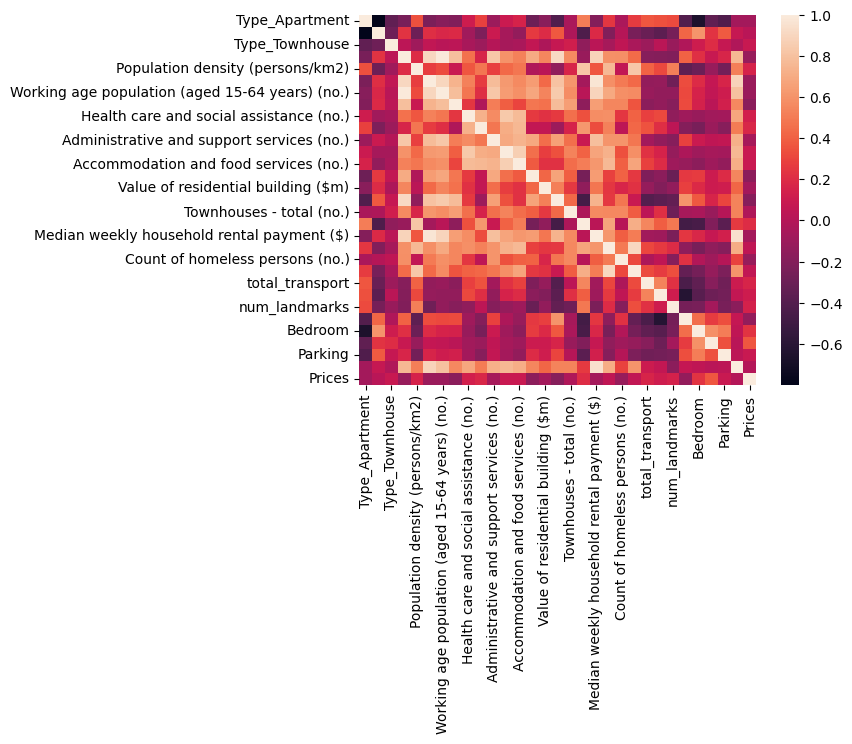

In [477]:
# Visualise heatmap
heatmap_features = features.copy()
heatmap_features.append('Prices')

heatmap_data = props[heatmap_features]
sns.heatmap(heatmap_data.corr())

In [478]:
len(features)

30

In [678]:
props['Prices'] = props['Prices'].astype(float)
X = props[features]
y = props['Prices']

# Perform stepwise selection with AIC
def stepwise_selection(X, y):
    predictors = X.columns.tolist()
    selected = []
    current_aic = float('inf')  # Initialize with a high value

    while predictors:
        aic_with_candidates = []
        for predictor in predictors:
            model = sm.OLS(y, sm.add_constant(X[selected + [predictor]])).fit()
            aic = model.aic
            aic_with_candidates.append((aic, predictor))

        aic_with_candidates.sort(reverse=True)
        best_aic, best_predictor = aic_with_candidates.pop()

        if best_aic < current_aic:
            current_aic = best_aic
            selected.append(best_predictor)
        else:
            break

    return selected

selected_predictors = stepwise_selection(X, y)
print("Selected predictors:", selected_predictors)

Selected predictors: ['Bathroom', 'Apartments - total (no.)', 'Bedroom', 'Houses - total (no.)', 'Health care and social assistance (no.)', 'Public administration and safety (no.)', 'Townhouses - total (no.)', 'num_landmarks', 'Rented (no.)', 'Median age - persons (years)', 'num_schools', 'Type_Apartment', 'Administrative and support services (no.)', 'distance to CBD', 'Used at least one form of public transport (train, tram, bus, ferry) (no.)', 'Count of homeless persons (no.)', 'Financial and insurance services (no.)', 'Accommodation and food services (no.)', 'Working age population (aged 15-64 years) (no.)', 'Parking', 'total_transport', 'Median weekly household rental payment ($)']


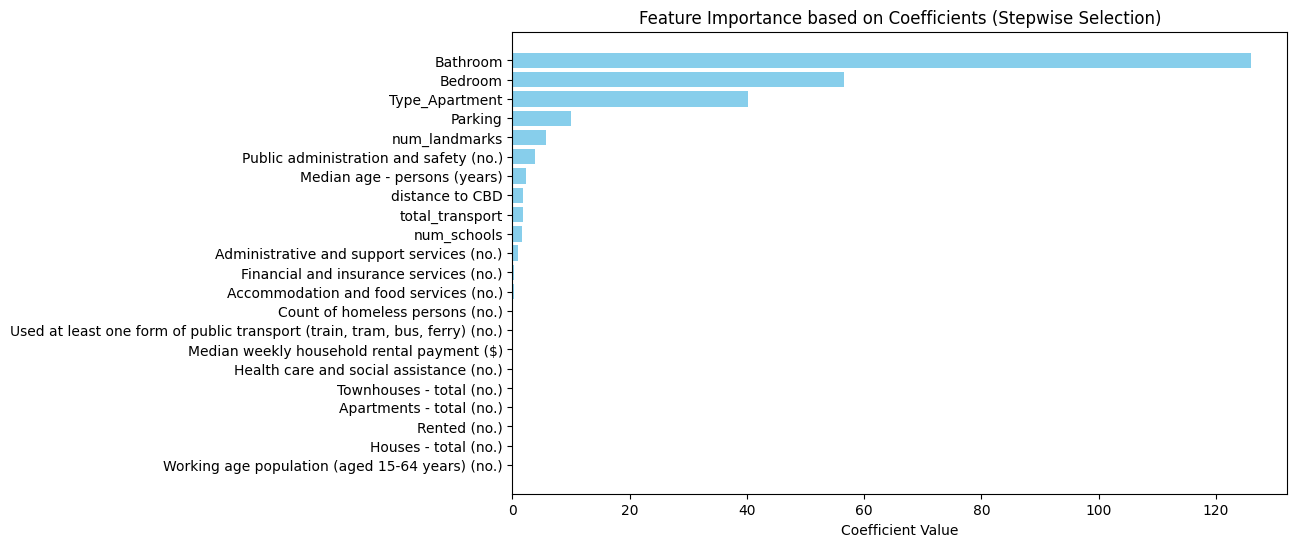

In [681]:
# Fit a linear regression model with the selected predictors
X_selected = X[selected_predictors]
X_selected = sm.add_constant(X_selected)  # Add a constant for the intercept
model = sm.OLS(y, X_selected).fit()

# Get the coefficients of the selected predictors
coefficients = abs(model.params)

# Sort the coefficients in descending order
coefficients = coefficients.sort_values(ascending=False)[1:]

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(coefficients.index, coefficients.values, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance based on Coefficients (Stepwise Selection)')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [633]:
selected_predictors

['Bathroom',
 'Apartments - total (no.)',
 'Bedroom',
 'Houses - total (no.)',
 'Health care and social assistance (no.)',
 'Public administration and safety (no.)',
 'Townhouses - total (no.)',
 'num_landmarks',
 'Rented (no.)',
 'Median age - persons (years)',
 'num_schools',
 'Type_Apartment',
 'Administrative and support services (no.)',
 'distance to CBD',
 'Used at least one form of public transport (train, tram, bus, ferry) (no.)',
 'Count of homeless persons (no.)',
 'Financial and insurance services (no.)',
 'Accommodation and food services (no.)',
 'Working age population (aged 15-64 years) (no.)',
 'Parking',
 'total_transport',
 'Median weekly household rental payment ($)']

In [684]:
# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create a list of alpha values to search (regularization strength)
alphas = np.logspace(-4, 4, 100)

# Initialize LassoCV with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)  # You can adjust the number of cross-validation folds (cv) as needed

# Fit the LassoCV model to your data
lasso_cv.fit(X, y)

# Get the optimal alpha value chosen by cross-validation
optimal_alpha = lasso_cv.alpha_
print(f"Optimal Alpha: {optimal_alpha}")

# Get the selected features (coefficients) from the Lasso model
selected_features = X.columns[lasso_cv.coef_ != 0]

# Evaluate the performance of the selected features using cross-validation
cross_val_scores = cross_val_score(lasso_cv, X[selected_features], y, cv=5, scoring='neg_mean_squared_error')

# Calculate the mean squared error (MSE) from the cross-validation scores
mse = -np.mean(cross_val_scores)

# Print the selected features and MSE
print(f"Selected Features: {selected_features}")


Optimal Alpha: 1.0974987654930568


/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.732e+07, tolerance: 1.210e+04
  model = cd_fast.enet_coordinate_descent(
/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.163e+07, tolerance: 1.636e+04
  model = cd_fast.enet_coordinate_descent(
/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Selected Features: Index(['Type_Apartment', 'Estimated resident population (no.)',
       'Population density (persons/km2)', 'Median age - persons (years)',
       'Working age population (aged 15-64 years) (no.)', 'Renter (no.)',
       'Health care and social assistance (no.)',
       'Financial and insurance services (no.)',
       'Administrative and support services (no.)',
       'Accommodation and food services (no.)',
       'Public administration and safety (no.)',
       'Value of residential building ($m)', 'Houses - total (no.)',
       'Townhouses - total (no.)', 'Apartments - total (no.)',
       'Median weekly household rental payment ($)', 'Rented (no.)',
       'Count of homeless persons (no.)',
       'Used at least one form of public transport (train, tram, bus, ferry) (no.)',
       'total_transport', 'num_schools', 'num_landmarks', 'distance to CBD',
       'Bedroom', 'Bathroom', 'Parking',
       'Median equivalised total household income (weekly) ($)'],
      dt

/Users/clardelia/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.484e+07, tolerance: 1.723e+04
  model = cd_fast.enet_coordinate_descent(


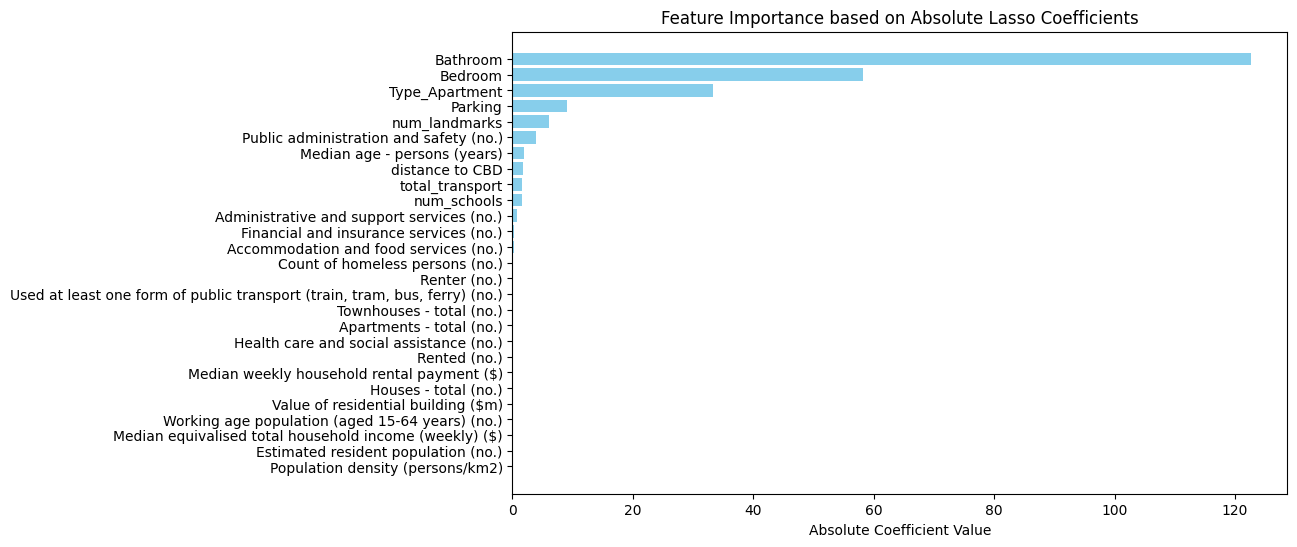

In [685]:
# Get the coefficients of the selected features
coefficients = lasso_cv.coef_

# Take the absolute values of the coefficients
abs_coefficients = np.abs(coefficients)

# Create a DataFrame to store feature names and their absolute coefficients
coef_df = pd.DataFrame({'Feature': X.columns, 'Absolute Coefficient': abs_coefficients})

# Filter the DataFrame to include only the selected features
coef_df = coef_df[coef_df['Feature'].isin(selected_features)]

# Sort the DataFrame by absolute coefficient values in descending order
coef_df = coef_df.reindex(coef_df['Absolute Coefficient'].sort_values(ascending=False).index)

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Absolute Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.title('Feature Importance based on Absolute Lasso Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()

In [635]:
# Identify features that selected in both feature selection
important_f = []
for feature in selected_features:
    if feature in selected_predictors:
        important_f.append(feature)

In [636]:
len(important_f)

22

In [686]:
important_f

['Type_Apartment',
 'Median age - persons (years)',
 'Working age population (aged 15-64 years) (no.)',
 'Health care and social assistance (no.)',
 'Financial and insurance services (no.)',
 'Administrative and support services (no.)',
 'Accommodation and food services (no.)',
 'Public administration and safety (no.)',
 'Houses - total (no.)',
 'Townhouses - total (no.)',
 'Apartments - total (no.)',
 'Median weekly household rental payment ($)',
 'Rented (no.)',
 'Count of homeless persons (no.)',
 'Used at least one form of public transport (train, tram, bus, ferry) (no.)',
 'total_transport',
 'num_schools',
 'num_landmarks',
 'distance to CBD',
 'Bedroom',
 'Bathroom',
 'Parking']

KMEANS

[0.6038638497372663, 0.5636653914293495, 0.5048444713667596, 0.395667846709115, 0.4166284058444774, 0.4336903252910309, 0.3864839888379694, 0.40050137016125054, 0.4036860806961784, 0.41707815048396746, 0.42179152939464465, 0.4233465850550846, 0.433555285644967, 0.44023770811419866, 0.45948864965521014, 0.4562448223412494, 0.458463972036354, 0.46389256468587003]


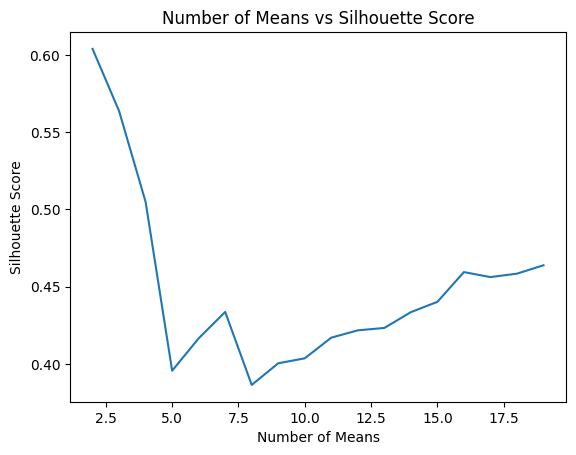

In [30]:
# Implementing K means

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20037)

X_train_norm = preprocessing.normalize(X_train)
X_test_norm = preprocessing.normalize(X_test)

K = range(2, 20)
fits = []
score = []

for k in K:
    # train the model for the current value of k on training data
    model = KMeans(n_clusters=k, random_state=0, n_init=10).fit(X_train_norm)
    
    # append the model to fits
    fits.append(model)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(X_train_norm, model.labels_, metric='euclidean'))

print(score)

sns.lineplot(x=K, y=score).set(title='Number of Means vs Silhouette Score', xlabel='Number of Means', ylabel='Silhouette Score')
plt.savefig('../plots/Silhouette Score.png')
# Lower the better for the score


0.3864839888379694


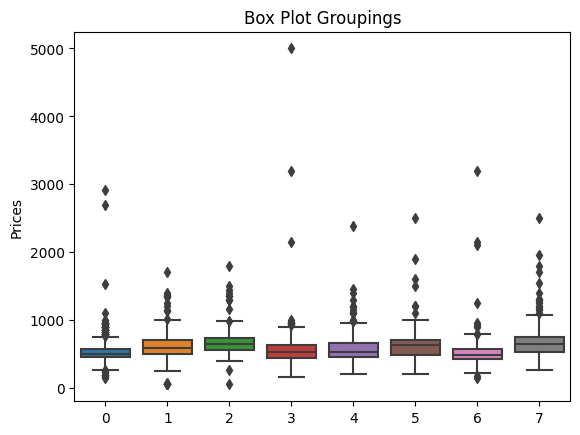

In [31]:
kmeans = KMeans(n_clusters=8, random_state=0, n_init=10)
kmeans.fit(X_train_norm)

print(silhouette_score(X_train_norm, kmeans.labels_, metric='euclidean'))


sns.boxplot(x = kmeans.labels_, y = y_train).set(title = 'Box Plot Groupings')